<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Feature Imputation for Subsurface Data Analytics in Python 


#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### Subsurface Machine Learning: Feature Imputation for Subsurface Data Analytics 

Here's a demonstration of feature imputation for subsurface modeling in Python. This is part of my Subsuface Machine Learning Course at the Cockrell School of Engineering at the University of Texas at Austin. 

#### What is Feature Ranking?

Feature imputation for missing sample data is required when we have:

* incomplete datasets

This is because many modeling workflows require exhaustive datasets.

* covariance / correlation require samples matched between features

* predictive models require all predictor feature values to formulate the prediction and calculate loss for model training and tuning


#### Description

Here's a simple, documented workflow, demonstration of multivariate feature imputation for feature engineering for subsurface modeling workflows. This should help you get started with building multivariate subsurface models.  

#### Feature Imputation

Here's some considerations for feature imputation:

##### Cause of Missing Samples

Missing at random (MAR) is not common and is not readily evaluated

* global random omission may not result in data bias and bias in the resulting models

* this is typically not the case as missing data often has a confounding feature, e.g. cost, rock rheology, project goals / prioritization, sampling to reduce uncertainty and maximize profitability instead of statistical representativity

##### Missing data consequences

More than reducing the amount of training and testing data, missing data, if not completely at random will result in:

* Biased sample statistics resulting in biased model training and testing

* Biased models with biased predictions with potentially no indication of the bias!

We must move beyond the commonly applied likewise delection, removal of all samples with any missing features.

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from sklearn.impute import SimpleImputer  # basic imputation method
from sklearn.impute import KNNImputer     # k-nearest neighbour imputation method
from sklearn.experimental import enable_iterative_imputer # required for MICE imputation
from sklearn.impute import IterativeImputer # MICE imputation

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [2]:
os.chdir("c:/PGE383")                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [11]:
df = pd.read_csv('unconv_MV_v4.csv')      # load our data table from a local file 
df = df.drop(['Prod'],axis = 1)                         # drop the response feature, production

We can preview the DataFrame by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [12]:
df.head(n=13)                             # we could also use this command for a table preview

,Well,Por,Perm,AI,Brittle,TOC,VR
0,1,12.08,2.92,2.80,81.40,1.16,2.31
1,2,12.38,3.53,3.22,46.17,0.89,1.88
2,3,14.02,2.59,4.01,72.80,0.89,2.72
3,4,17.67,6.75,2.63,39.81,1.08,1.88
4,5,17.52,4.57,3.18,10.94,1.51,1.90
5,6,14.53,4.81,2.69,53.60,0.94,1.67
6,7,13.49,3.60,2.93,63.71,0.80,1.85
7,8,11.58,3.03,3.25,53.00,0.69,1.93
8,9,12.52,2.72,2.43,65.77,0.95,1.98
9,10,13.25,3.94,3.71,66.20,1.14,2.65


This dataset has features from 200 unconventional wells including: 

0. well index
1. well average porosity (%) 
2. permeability (mD)
3. accoustic impedance (kg/m2s*10^6)
4. brittness ratio (%) 
5. total organic carbon (%) 
6. vitrinite reflectance (%)
8. normalized initial production 90 day average (MCFPD). (removed) 

Note, the dataset is synthetic, but has realistic ranges and general multivariate relationships.

Ranking features is really an effort to understand the features and their relationships with eachother.  We will start with basic data visualization and move to more complicated methods such are partial correlation and recursive feature elimination.

### Remove Some Data 

Let's select a proportioin of NaN values, values to set as missing

```python
proportion_NaN = 0.1
```
Then we can make a boolean array 

1. make an ndarray of same shape (number rows and columns) as the DataFrame of uniform[0,1] distributed values

```python
np.random.random(df.shape)
```

2. check condition of less than the identified proportion to make a boolean ndarray of same size, true if less than the proportion. The result will be the correct proportion (within error) of random true values.

```python
remove = np.random.random(df.shape) < proportion_NaN
```

3. apply the mask to remove the identified values from the DataFrame

```python
df_mask = df.mask(remove)
```


In [13]:
proportion_NaN = 0.1                              # proportion of values in DataFrame to remove

remove = np.random.random(df.shape) < proportion_NaN # make the boolean array for removal
print('Fraction of removed values in mask ndarray = ' + str(round(remove.sum()/remove.size,3)) + '.')

df_mask = df.mask(remove)

print('Fraction of nan values in the DataFrame = ' + str(round(df_mask.isnull().sum().sum()/(df_mask.shape[0]*df_mask.shape[1]),3)) + '.')

Fraction of removed values in mask ndarray = 0.099.
Fraction of nan values in the DataFrame = 0.099.


We now have a new DataFrame with some missing data.

* Let's do a .head() preview to abserve the NaN values scattered throughout the dataset

In [14]:
df_mask.head(n=13)

,Well,Por,Perm,AI,Brittle,TOC,VR
0,1.0,12.08,2.92,2.80,81.40,1.16,2.31
1,2.0,12.38,3.53,3.22,NaN,0.89,1.88
2,3.0,14.02,NaN,4.01,72.80,0.89,2.72
3,NaN,17.67,6.75,NaN,39.81,1.08,1.88
4,5.0,17.52,4.57,3.18,10.94,1.51,1.90
5,6.0,14.53,4.81,2.69,53.60,0.94,NaN
6,7.0,13.49,3.60,2.93,63.71,0.80,1.85
7,8.0,11.58,3.03,3.25,53.00,0.69,1.93
8,9.0,12.52,2.72,2.43,65.77,NaN,1.98
9,10.0,13.25,3.94,3.71,66.20,1.14,2.65


### Evaluation of the Data Coverage

Let's calculate the amount of missing data.

In [15]:
df_mask.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Well,176.0,100.227273,58.146559,1.00,49.7500,99.50,150.2500,200.00
Por,182.0,15.041703,2.964824,6.55,12.9850,15.13,17.4275,23.55
Perm,180.0,4.337722,1.762936,1.13,3.1225,4.01,5.3700,9.87
AI,178.0,2.972135,0.577175,1.28,2.5500,2.97,3.3400,4.63
Brittle,185.0,48.032216,14.489598,10.94,37.4000,49.41,58.2500,84.33
TOC,180.0,1.004167,0.488063,-0.19,0.6525,1.04,1.3700,2.18
VR,180.0,1.974944,0.310079,0.93,1.7700,1.97,2.1500,2.87


We can see the counts of available values for each feature, less than the total number of samples due to missing values. 

Let's make a plot to indicate data completeness for each feature

* this is a useful summarization

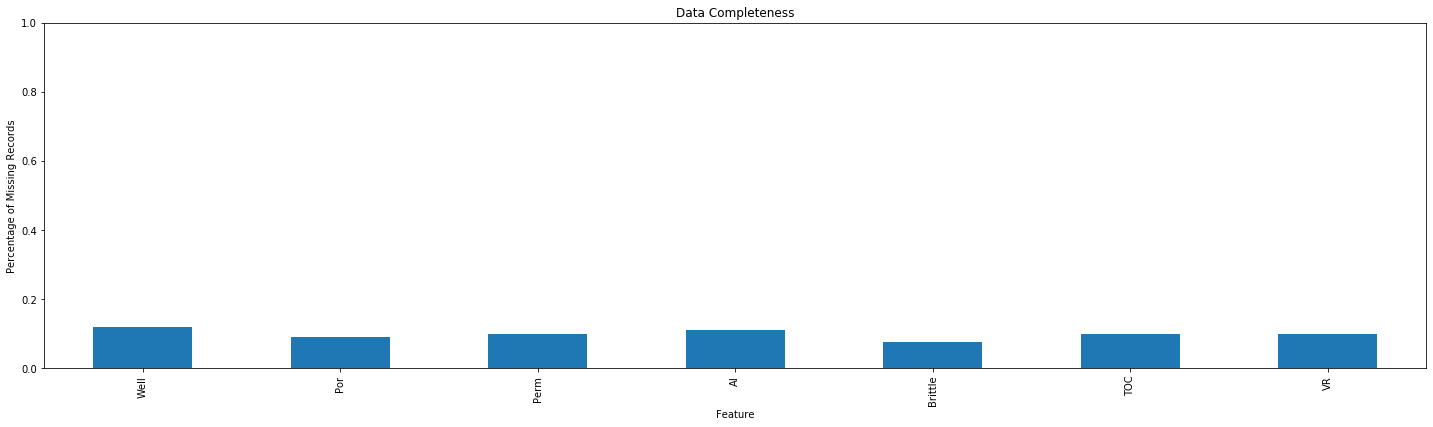

In [16]:
(df_mask.isnull().sum()/len(df)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.ylim([0,1.0])
plt.show()

This leads to the first data imputation method, feature selection. 

### Imputation Method \#1 - Feature Selection

Data completeness should be considered in feature selection.

* if there is low data completeness, high percentage of missing samples, for a feature then the feature may be removed.

One method is to use the .drop() DataFrame function.

```python
df_test = df_mask.drop('VR',axis = 1)
```

We use axis = 1 to drop a feature (as above) and demonstrated below.

In [17]:
df_test = df_mask.drop('VR',axis = 1)
df_test.head(n=5)

,Well,Por,Perm,AI,Brittle,TOC
0,1.0,12.08,2.92,2.80,81.40,1.16
1,2.0,12.38,3.53,3.22,NaN,0.89
2,3.0,14.02,NaN,4.01,72.80,0.89
3,NaN,17.67,6.75,NaN,39.81,1.08
4,5.0,17.52,4.57,3.18,10.94,1.51


### Imputation Method \#2 - Sample Selection

Let's check the coverage by sample in the DataFrame.

* we use the axis=1 parameter in the sum command to sum NaN values over the rows, samples, of the DataFrame.  

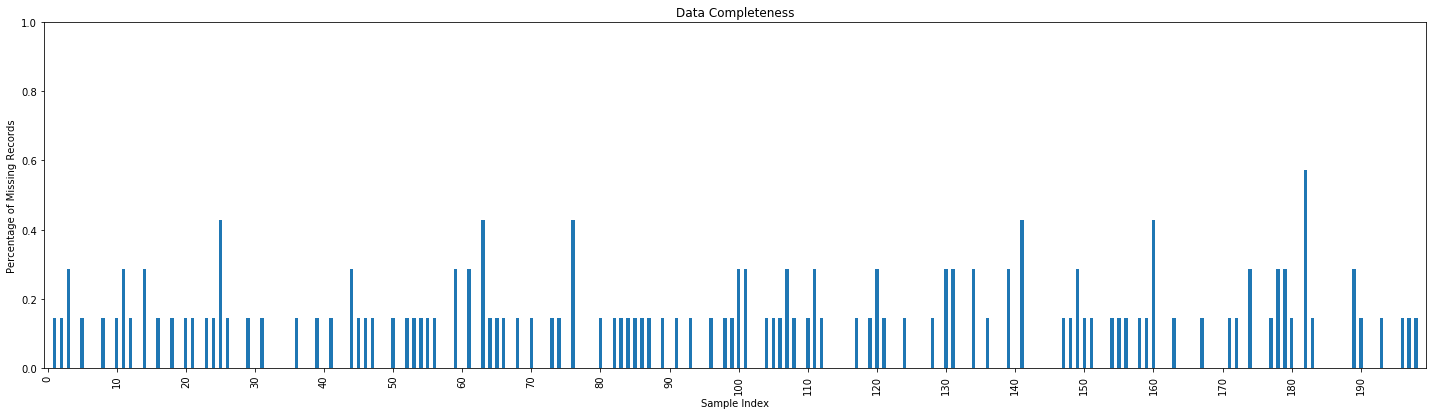

In [22]:
(df_mask.isnull().sum(axis=1)/len(df.columns)).plot(kind = 'bar')
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=1.2, wspace=0.2, hspace=0.2) # plot formatting
plt.xlabel('Sample Index'); plt.ylabel('Percentage of Missing Records'); plt.title('Data Completeness')
plt.xticks(np.arange(0,len(df_mask),10),np.arange(0,len(df_mask),10))
plt.ylim([0,1.0])
plt.show()

If we identified samples with low data completeness, high percentage of missing samples, for a sample then the sample may be removed.

Once again we use the .drop() DataFrame function.

```python
df_test = df_mask.drop('Water',axis = 1)
```

This time we use axis = 0 to drop a list of samples and demonstrated below.

1. We need to make a list of the sample indices with too many missing samples

```python
(df_mask.isnull().sum(axis=1)/len(df.columns)) > max_proportion_missing_by_sample 
```

2. This is a tupe, let's convert it to a ndarray then we ensure strip it to just the 1D values 

```python
index_low_coverage_samples = np.asarray(np.where(low_coverage_samples == True))[0]
```

3. Now we are ready to apply our boolean array of length number of samples with True for too many missing values to remove these samples by index.

```python
df_test2 = df_mask.drop(index = index_low_coverage_samples,axis = 0)
```

In [23]:
max_proportion_missing_by_sample = 0.2

low_coverage_samples = (df_mask.isnull().sum(axis=1)/len(df.columns)) > max_proportion_missing_by_sample 
index_low_coverage_samples = np.asarray(np.where(low_coverage_samples == True))[0]

df_test2 = df_mask.drop(index = index_low_coverage_samples,axis = 0)
df_test2.head(n=5)

,Well,Por,Perm,AI,Brittle,TOC,VR
0,1.0,12.08,2.92,2.80,81.40,1.16,2.31
1,2.0,12.38,3.53,3.22,NaN,0.89,1.88
2,3.0,14.02,NaN,4.01,72.80,0.89,2.72
4,5.0,17.52,4.57,3.18,10.94,1.51,1.90
5,6.0,14.53,4.81,2.69,53.60,0.94,NaN


### Imputation Method \#3 - Likewise Deletion

This is the method of removing all samples that have any missing values.

* this approach ensures complete data while technically avoiding the need for imputation

* no need for a imputation model decision 

* often removes important information

* maximizes data bias if information is not missing at random (MAR)

While this method is often applied, it is not recommended.

We can use the dropna() function.

* with subset we can only consider a list of features

* how can be set to 'any' for drop if any missing values and 'all' drop if all are missing

* inplace true will overwrite the DataFrame and has no output while false will pass the new dataframe as a copy

,Well,Por,Perm,AI,Brittle,TOC,VR
0,1.0,12.08,2.92,2.80,81.40,1.16,2.31
4,5.0,17.52,4.57,3.18,10.94,1.51,1.90
6,7.0,13.49,3.60,2.93,63.71,0.80,1.85
7,8.0,11.58,3.03,3.25,53.00,0.69,1.93
9,10.0,13.25,3.94,3.71,66.20,1.14,2.65
13,14.0,17.39,4.95,2.55,56.43,1.87,2.19
15,16.0,11.34,2.72,3.43,58.03,0.57,2.15
17,18.0,15.58,3.67,2.53,29.43,1.35,1.88
19,20.0,12.47,2.53,3.54,48.82,0.90,2.54
22,23.0,12.62,2.39,2.38,15.68,1.00,1.48


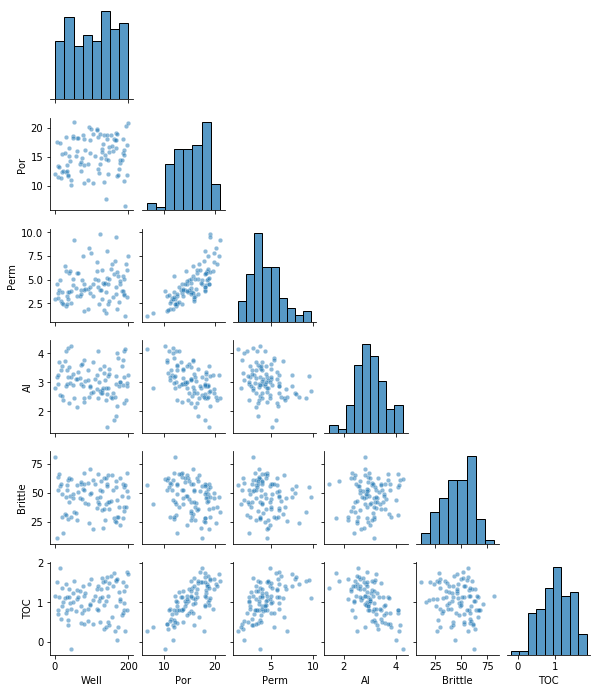

In [27]:
df_likewise = df_mask.dropna(how='any',inplace=False)

sns.pairplot(df_likewise.iloc[:,:-1], plot_kws={'alpha':0.5,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_likewise.head(n = 13)

### Modeling Methods

Let's add a feature indicating if there are missing values for a specific sample

* this way we can indicate samples that have had features imputed for evaluation of the results

In [28]:
df_mask['Imputed'] = (df_mask.isnull().sum(axis=1)) > 0
df_mask.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Imputed
0,1.0,12.08,2.92,2.80,81.40,1.16,2.31,False
1,2.0,12.38,3.53,3.22,NaN,0.89,1.88,True
2,3.0,14.02,NaN,4.01,72.80,0.89,2.72,True
3,NaN,17.67,6.75,NaN,39.81,1.08,1.88,True
4,5.0,17.52,4.57,3.18,10.94,1.51,1.90,False


### Imputation Method \#4 - Replace with a Constant

This is the method of replacing the missing values with the mean over the feature. 

,Well,Por,Perm,AI,Brittle,TOC,VR,Imputed
0,1.00,12.08,2.92,2.80,81.40,1.16,2.31,False
1,2.00,12.38,3.53,3.22,0.01,0.89,1.88,True
2,3.00,14.02,0.01,4.01,72.80,0.89,2.72,True
3,0.01,17.67,6.75,0.01,39.81,1.08,1.88,True
4,5.00,17.52,4.57,3.18,10.94,1.51,1.90,False


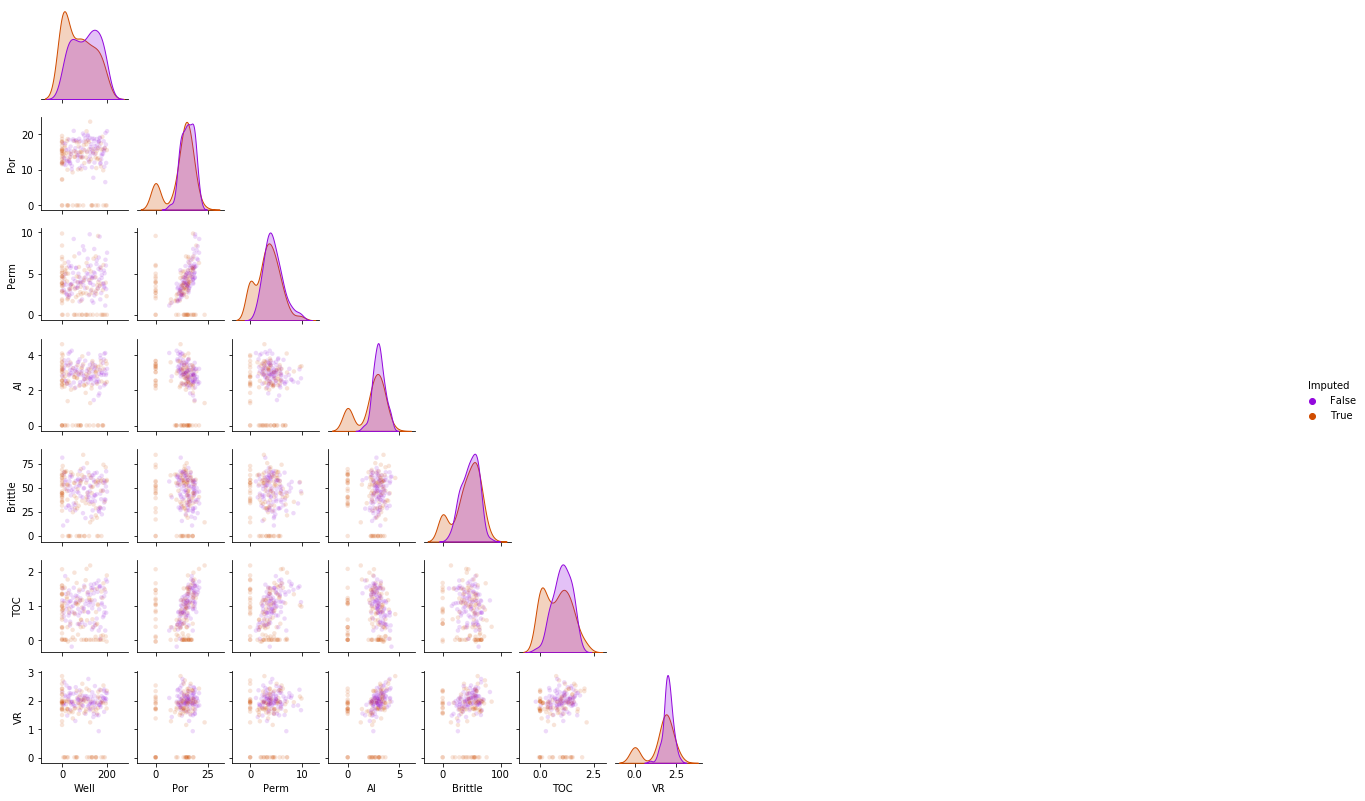

In [30]:
df_constant = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
constant_imputer = SimpleImputer(strategy='constant',fill_value = 0.01)
df_constant.iloc[:,:] = constant_imputer.fit_transform(df_constant)

sns.pairplot(df_constant.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant.head(n=5)

### Imputation Method \#6 - Replace with the Mean

This is the method of replacing the missing values with the mean, arithmetic average, over the feature. 

,Well,Por,Perm,AI,Brittle,TOC,VR,Imputed
0,1.000000,12.08,2.920000,2.800000,81.400000,1.16,2.31,0.0
1,2.000000,12.38,3.530000,3.220000,48.032216,0.89,1.88,1.0
2,3.000000,14.02,4.337722,4.010000,72.800000,0.89,2.72,1.0
3,100.227273,17.67,6.750000,2.972135,39.810000,1.08,1.88,1.0
4,5.000000,17.52,4.570000,3.180000,10.940000,1.51,1.90,0.0


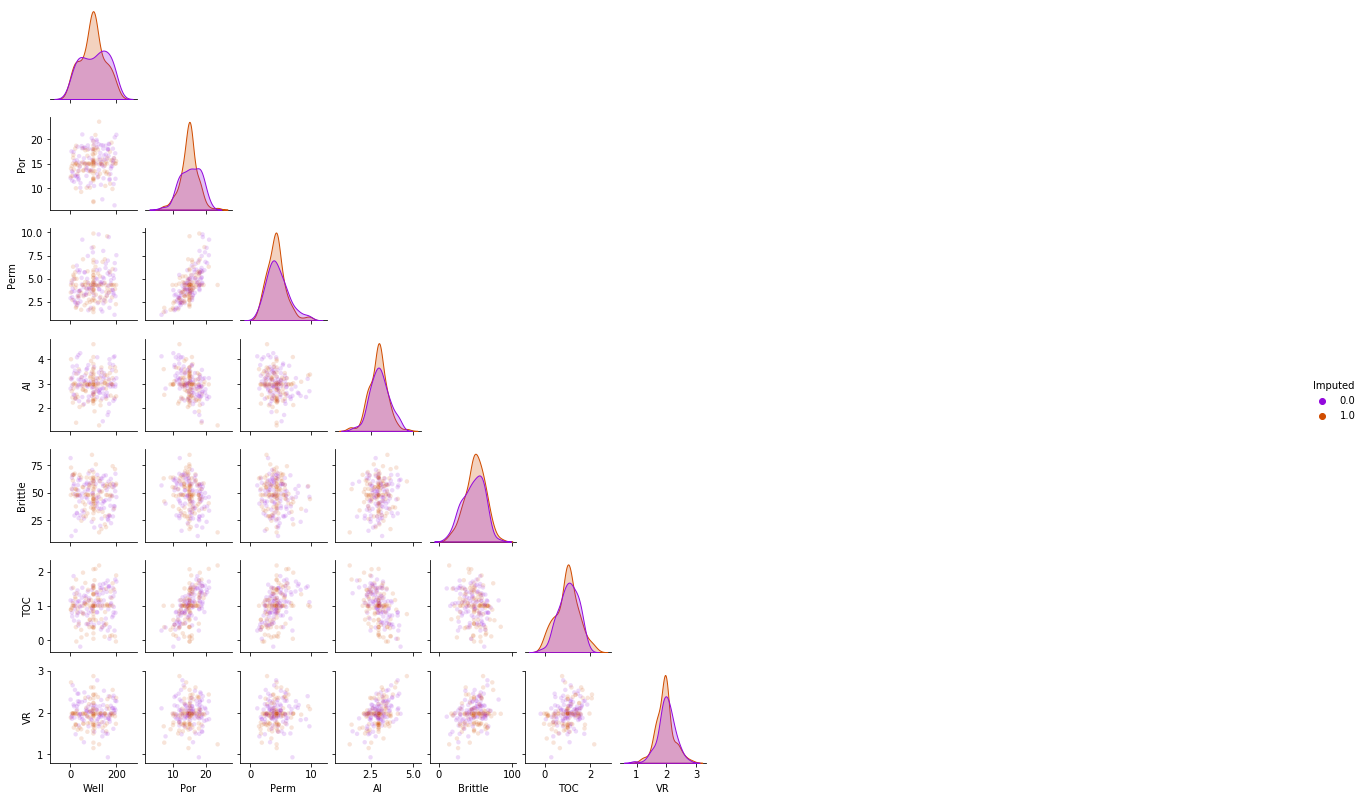

In [33]:
df_mean = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
mean_imputer = SimpleImputer(strategy='mean')
df_mean.iloc[:,:] = mean_imputer.fit_transform(df_mean)

sns.pairplot(df_mean.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant.head(n=5)
df_mean.head(n=5)

### Imputation Method \#6 - Replace with the Mode

This is the method of replacing the missing values with the most frequent value, mode, over the feature. 

* it appears that this method is not calculating a mode based on a data binning and may fail to find a model for floats

,Well,Por,Perm,AI,Brittle,TOC,VR,Imputed
0,1.0,12.08,2.92,2.80,81.40,1.16,2.31,False
1,2.0,12.38,3.53,3.22,40.24,0.89,1.88,True
2,3.0,14.02,4.66,4.01,72.80,0.89,2.72,True
3,1.0,17.67,6.75,2.45,39.81,1.08,1.88,True
4,5.0,17.52,4.57,3.18,10.94,1.51,1.90,False


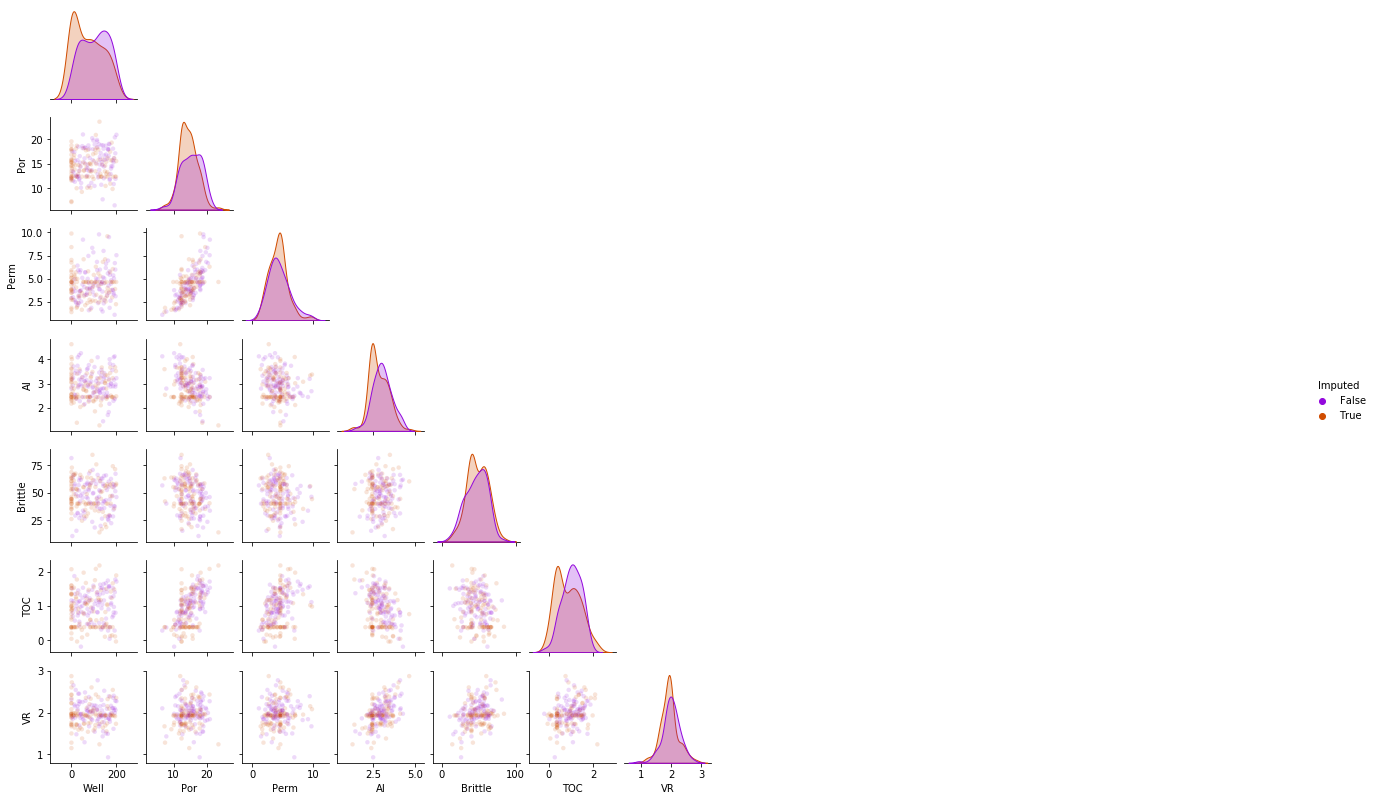

In [34]:
df_mode = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
mode_imputer = SimpleImputer(strategy='most_frequent')
df_mode.iloc[:,:] = mode_imputer.fit_transform(df_mode)

sns.pairplot(df_mode.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant.head(n=5)
df_mode.head(n=5)

### Imputation Method \#7 - Replace with the n-nearest Neighbor estimation

This is the method of replacing the missing values with the k-nearest neighbour prediction model

* see the section on k-nearest neighbour for explanation of the method, assumptions and hyperparameters 

* the available data is applied to predict at the missing values in features space

Since the k-nearest neighbor method is a lazy learner, imputed values are calculated in a single pass over the missing values

* there are not separate train and predict steps

,Well,Por,Perm,AI,Brittle,TOC,VR,Imputed
0,1.0,12.08,2.92,2.80,81.40,1.16,2.31,False
1,2.0,12.38,3.53,3.22,40.24,0.89,1.88,True
2,3.0,14.02,4.66,4.01,72.80,0.89,2.72,True
3,1.0,17.67,6.75,2.45,39.81,1.08,1.88,True
4,5.0,17.52,4.57,3.18,10.94,1.51,1.90,False


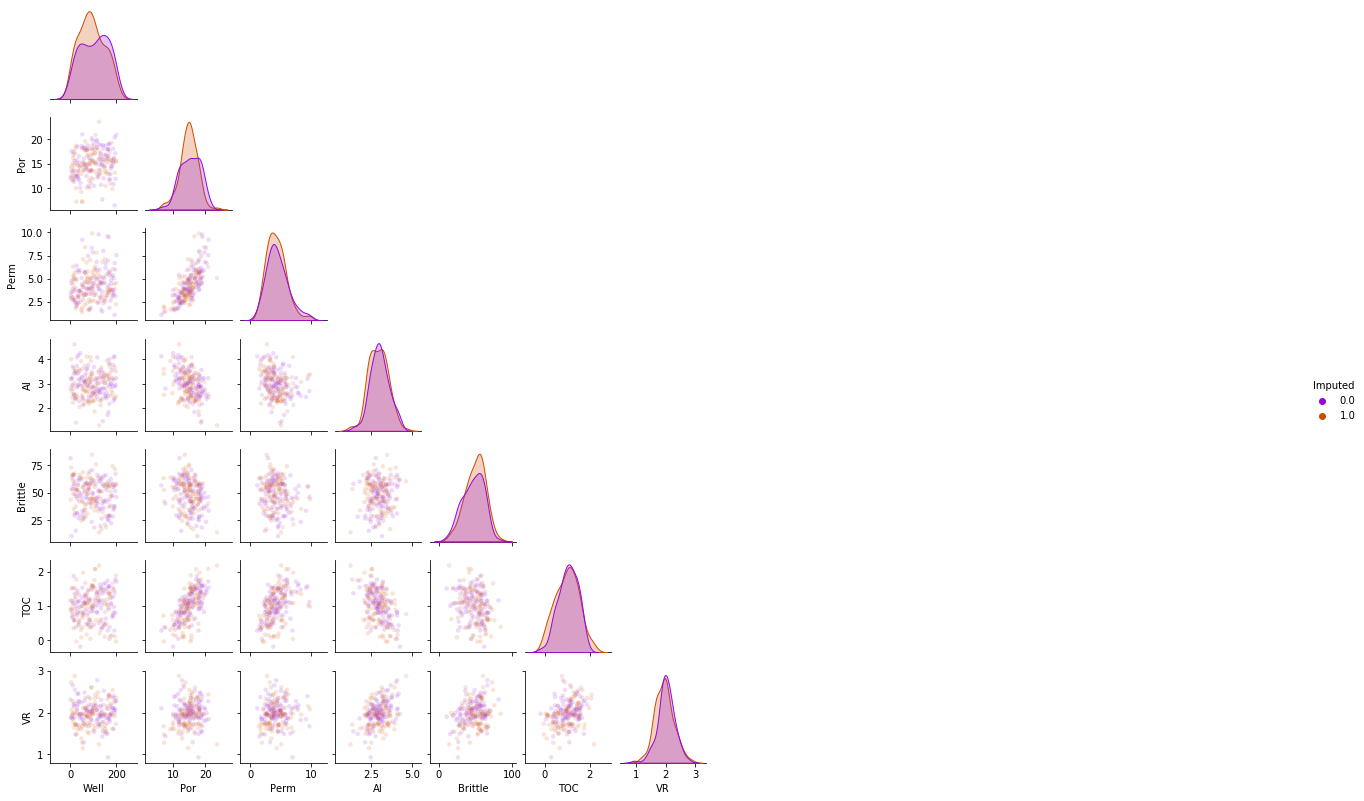

In [35]:
df_knn = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_knn.iloc[:,:] = knn_imputer.fit_transform(df_knn)

sns.pairplot(df_knn.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant.head(n=5)
df_mode.head(n=5)

### Imputation Method \#8 - Multivariate imputation by chained equations 

This is the method of replacing the missing values with the k-nearest neighbour prediction model

1. Substitute random values from $𝐹_{𝑋_{𝑖=1,\ldots,𝑚}}(𝑋_{𝑖=1,\ldots,𝑚})$ for missing values
2. Sequentially predict missing values for a feature with others
3. Iterative until convergence criteria, usually multivariate statistics
4. Repeat for multiple realizations of the dataset

The default predictor is BayesianRidge().

* we can specify the maximum number of iterations. The last computed imputations are returned.


,Well,Por,Perm,AI,Brittle,TOC,VR,Imputed
0,1.0,12.08,2.92,2.80,81.40,1.16,2.31,False
1,2.0,12.38,3.53,3.22,40.24,0.89,1.88,True
2,3.0,14.02,4.66,4.01,72.80,0.89,2.72,True
3,1.0,17.67,6.75,2.45,39.81,1.08,1.88,True
4,5.0,17.52,4.57,3.18,10.94,1.51,1.90,False


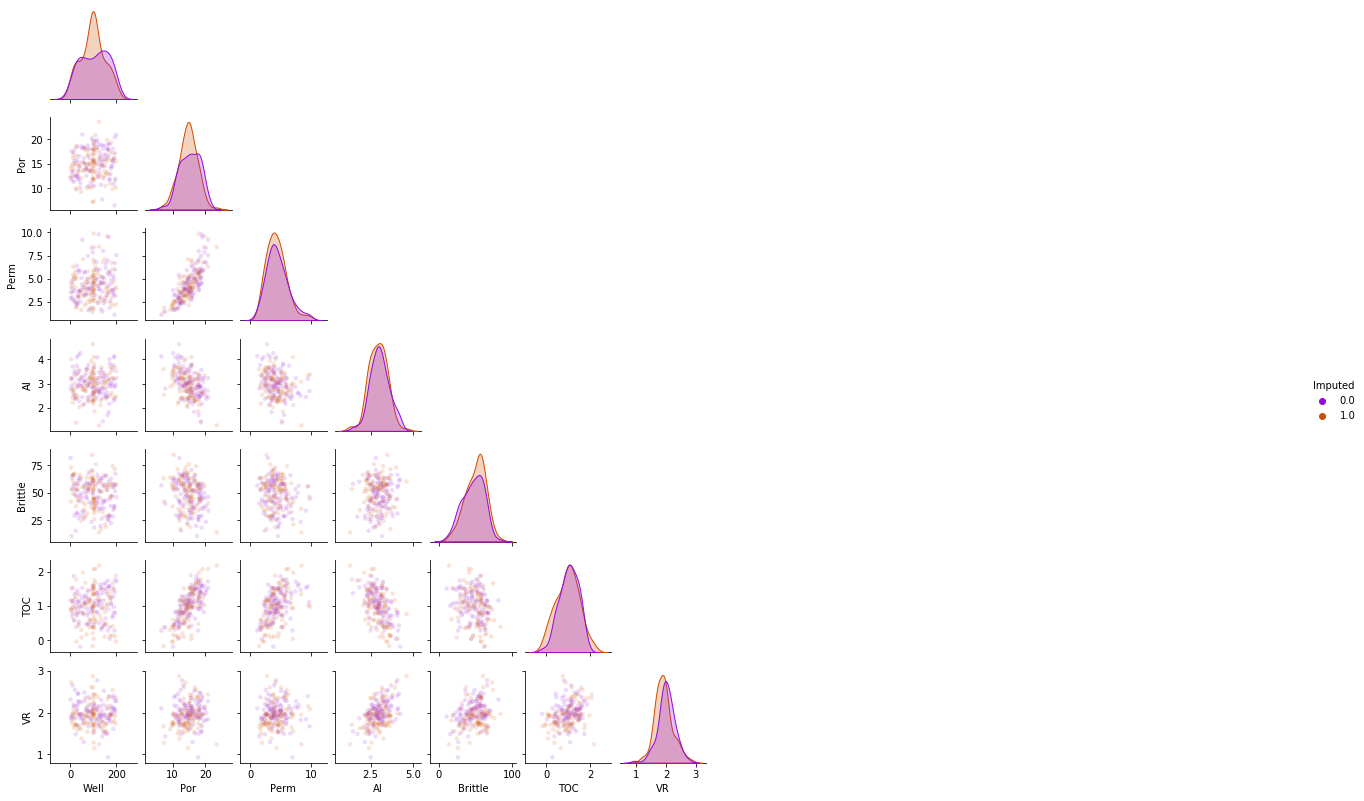

In [36]:
df_mice = df_mask.copy(deep=True)                         # make a deep copy of the DataFrame
mice_imputer = IterativeImputer()
df_mice.iloc[:,:] = mice_imputer.fit_transform(df_mice)

sns.pairplot(df_mice.iloc[:,:], hue="Imputed", plot_kws={'alpha':0.15,'s':20}, palette = 'gnuplot', corner=True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.1, hspace=0.2)
df_constant.head(n=5)
df_mode.head(n=5)

#### Comments

This was a basic demonstration of multivariate feature imputation.

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
